In [25]:
#Author: Joe Alsko
#This notebook is used to find highest ride frequency days per community area and tip ratios per community area

# %pylab inline
import math
import pandas as pd
import numpy as np
import shapefile as shp
import matplotlib.pylab as plt
import matplotlib as mpl
from dateutil.parser import parse
import time
from scipy import stats
from pymining import itemmining

%matplotlib inline
pd.options.display.max_rows = 250

In [2]:
# Read the data from each month in 2016 and save them into monthly dataframe called jan, feb, mar,...
jan = pd.read_csv('chicago_taxi_trips_2016_01.csv')
feb = pd.read_csv('chicago_taxi_trips_2016_02.csv')
mar = pd.read_csv('chicago_taxi_trips_2016_03.csv')
apr = pd.read_csv('chicago_taxi_trips_2016_04.csv')
may = pd.read_csv('chicago_taxi_trips_2016_05.csv')
june = pd.read_csv('chicago_taxi_trips_2016_06.csv')
july = pd.read_csv('chicago_taxi_trips_2016_07.csv')
aug = pd.read_csv('chicago_taxi_trips_2016_08.csv')
sept = pd.read_csv('chicago_taxi_trips_2016_09.csv')
octo = pd.read_csv('chicago_taxi_trips_2016_10.csv')
nov = pd.read_csv('chicago_taxi_trips_2016_11.csv')
dec = pd.read_csv('chicago_taxi_trips_2016_12.csv')

# Clean (Remove) the columns and rows that are not applicable, unknown or missing values from each month
cleaned_2016 = pd.DataFrame()
dfYear = []
for mo in jan, feb, mar, apr, may, june, july, aug, sept, octo, nov, dec:
    mo = mo.drop(['taxi_id','pickup_census_tract', 'dropoff_census_tract','extras','tolls','trip_total','company','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'], axis=1)
    mo = mo[(mo['pickup_community_area'].notnull()) & (mo['dropoff_community_area'].notnull())]
    mo = mo.fillna(0)
    mo = mo.loc[(mo["trip_seconds"] > 0) & (mo["trip_miles"] > 0) & (mo["fare"] > 0) ]
    dfYear.append(mo)

cleaned_2016 = pd.concat(dfYear, axis=0, join='outer', ignore_index=True)
cleaned_2016.info()
cleaned_2016.head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13335042 entries, 0 to 13335041
Data columns (total 9 columns):
trip_start_timestamp      object
trip_end_timestamp        object
trip_seconds              float64
trip_miles                float64
pickup_community_area     float64
dropoff_community_area    float64
fare                      float64
tips                      float64
payment_type              object
dtypes: float64(6), object(3)
memory usage: 915.6+ MB


,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,payment_type
13335022,2016-12-20 19:00:00,2016-12-20 19:15:00,660.0,0.6,32.0,32.0,6.75,0.00,Cash
13335023,2016-12-23 01:00:00,2016-12-23 01:00:00,360.0,2.4,24.0,28.0,9.00,3.00,Credit Card
13335024,2016-12-16 21:30:00,2016-12-16 21:30:00,780.0,2.1,24.0,7.0,9.50,0.00,Cash
13335025,2016-12-21 08:30:00,2016-12-21 08:30:00,300.0,0.8,32.0,32.0,5.75,3.00,Credit Card
13335026,2016-12-17 21:15:00,2016-12-17 21:15:00,60.0,0.1,8.0,8.0,3.50,0.00,Cash
13335027,2016-12-31 22:00:00,2016-12-31 22:15:00,1380.0,3.5,28.0,8.0,14.25,0.00,Cash
13335028,2016-12-16 16:45:00,2016-12-16 16:45:00,420.0,0.7,32.0,32.0,6.25,0.00,Cash
13335029,2016-12-11 12:00:00,2016-12-11 12:00:00,120.0,0.5,32.0,28.0,6.00,0.00,Cash
13335030,2016-12-11 19:30:00,2016-12-11 19:30:00,240.0,0.8,8.0,8.0,5.50,0.00,Cash
13335031,2016-12-17 13:00:00,2016-12-17 13:15:00,540.0,0.2,8.0,33.0,11.00,0.00,Cash


In [33]:
#Add month and day attributes to dataset for later analysis
pd.options.mode.chained_assignment = None  # default='warn'

start = time.time()

#method for getting month number from timestamp
def getMonth(row):
    return "m" + row['trip_start_timestamp'].split("-")[1]

#method for getting day number from timestamp
def getDay(row):
    return "d" + row['trip_start_timestamp'].split("-")[2].split(" ")[0]

cleaned_2016['month'] = cleaned_2016.apply(getMonth,axis=1)
cleaned_2016['day'] = cleaned_2016.apply(getDay,axis=1)

print("Finished evaluating in " + str(time.time()-start) + " seconds")
    
cleaned_2016.head(10)

13335042
Finished evaluating in 554.5808699131012 seconds


,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,payment_type,month,day
0,2016-1-13 06:15:00,2016-1-13 06:15:00,180.0,0.4,24.0,24.0,4.50,0.00,Cash,m1,d13
1,2016-1-23 17:30:00,2016-1-23 17:30:00,480.0,1.1,6.0,6.0,7.00,0.00,Cash,m1,d23
2,2016-1-8 18:15:00,2016-1-8 18:45:00,1080.0,6.2,8.0,3.0,17.75,0.00,Cash,m1,d8
3,2016-1-26 04:15:00,2016-1-26 04:15:00,60.0,0.2,16.0,16.0,3.75,0.00,Cash,m1,d26
4,2016-1-25 09:00:00,2016-1-25 09:00:00,480.0,1.3,8.0,8.0,7.00,1.00,Credit Card,m1,d25
5,2016-1-13 18:30:00,2016-1-13 19:00:00,1380.0,5.1,32.0,31.0,17.25,5.18,Credit Card,m1,d13
6,2016-1-3 07:45:00,2016-1-3 08:00:00,480.0,0.1,41.0,69.0,9.00,0.00,Cash,m1,d3
7,2016-1-25 10:30:00,2016-1-25 10:30:00,720.0,2.2,7.0,28.0,10.00,0.00,Cash,m1,d25
8,2016-1-1 19:30:00,2016-1-1 19:45:00,660.0,4.1,8.0,6.0,11.85,3.00,Credit Card,m1,d1
9,2016-1-20 07:30:00,2016-1-20 07:45:00,720.0,2.5,8.0,28.0,10.25,1.75,Credit Card,m1,d20


In [34]:
#Build separate dataset with just top 3 community areas
topAreas = cleaned_2016[cleaned_2016.pickup_community_area.isin([8.0,28.0,32.0])]
topAreas.head(20)


,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,payment_type,month,day
2,2016-1-8 18:15:00,2016-1-8 18:45:00,1080.0,6.20,8.0,3.0,17.75,0.00,Cash,m1,d8
4,2016-1-25 09:00:00,2016-1-25 09:00:00,480.0,1.30,8.0,8.0,7.00,1.00,Credit Card,m1,d25
5,2016-1-13 18:30:00,2016-1-13 19:00:00,1380.0,5.10,32.0,31.0,17.25,5.18,Credit Card,m1,d13
8,2016-1-1 19:30:00,2016-1-1 19:45:00,660.0,4.10,8.0,6.0,11.85,3.00,Credit Card,m1,d1
9,2016-1-20 07:30:00,2016-1-20 07:45:00,720.0,2.50,8.0,28.0,10.25,1.75,Credit Card,m1,d20
10,2016-1-8 19:30:00,2016-1-8 19:30:00,720.0,0.20,32.0,24.0,12.25,2.00,Credit Card,m1,d8
11,2016-1-14 14:15:00,2016-1-14 14:45:00,1740.0,11.50,32.0,56.0,31.25,0.00,Cash,m1,d14
12,2016-1-2 17:45:00,2016-1-2 17:45:00,240.0,0.60,8.0,32.0,4.85,0.00,Cash,m1,d2
13,2016-1-13 19:00:00,2016-1-13 19:15:00,600.0,0.90,8.0,8.0,7.00,1.11,Credit Card,m1,d13
15,2016-1-1 14:30:00,2016-1-1 14:45:00,1020.0,7.80,8.0,4.0,18.85,0.00,Cash,m1,d1


In [44]:
#Get frequent sets of month/day and community area
date_tuples  = topAreas[['month', 'day', 'pickup_community_area']].apply(tuple, axis=1)
relim_input = itemmining.get_relim_input(date_tuples)
report = itemmining.relim(relim_input, min_support=5000) #Relim frequent itemset algorithm
report

{frozenset({'d31'}): 151535,
 frozenset({'d31', 'm12'}): 15943,
 frozenset({8.0, 'm12', 'd31'}): 10189,
 frozenset({'d31', 'm10'}): 20354,
 frozenset({32.0, 'm10', 'd31'}): 8420,
 frozenset({8.0, 'm10', 'd31'}): 9186,
 frozenset({'d31', 'm1'}): 14134,
 frozenset({8.0, 'm1', 'd31'}): 9916,
 frozenset({'d31', 'm8'}): 24096,
 frozenset({'m8', 32.0, 'd31'}): 9895,
 frozenset({'m8', 8.0, 'd31'}): 10780,
 frozenset({'d31', 'm7'}): 21980,
 frozenset({32.0, 'm7', 'd31'}): 6229,
 frozenset({8.0, 'm7', 'd31'}): 13513,
 frozenset({'d31', 'm5'}): 24461,
 frozenset({32.0, 'm5', 'd31'}): 9376,
 frozenset({8.0, 'm5', 'd31'}): 11394,
 frozenset({'d31', 'm3'}): 30567,
 frozenset({32.0, 'd31', 'm3'}): 12465,
 frozenset({8.0, 'd31', 'm3'}): 13861,
 frozenset({28.0, 'd31'}): 19943,
 frozenset({32.0, 'd31'}): 52753,
 frozenset({8.0, 'd31'}): 78839,
 frozenset({'d30'}): 263819,
 frozenset({'d30', 'm9'}): 27964,
 frozenset({'d30', 32.0, 'm9'}): 10694,
 frozenset({'d30', 8.0, 'm9'}): 13506,
 frozenset({'d30',

In [55]:
#Method for viewing sorted results from frequent itemset above per community area
cleaned_report = {8.0:{}, 32.0:{}, 28.0:{}} #Numbers of community areas map to dictionaries
for s in report.keys():
    if len(s) >= 3: #Relim algorithm returns itemsets of any length, so we need to only get 3-long sets
        for k in cleaned_report.keys():
            if k in s:
                cleaned_report[k][s] = report[s]
                break;
                
sorted(cleaned_report[32.0].items(), key=lambda x:x[1]) #Show sorted frequent itemsets for community area 32

[(frozenset({32.0, 'd17', 'm7'}), 5012),
 (frozenset({32.0, 'd23', 'm1'}), 5026),
 (frozenset({32.0, 'm12', 'd27'}), 5054),
 (frozenset({32.0, 'm10', 'd8'}), 5058),
 (frozenset({32.0, 'm10', 'd29'}), 5130),
 (frozenset({32.0, 'd23', 'm4'}), 5136),
 (frozenset({32.0, 'd16', 'm1'}), 5175),
 (frozenset({32.0, 'd24', 'm7'}), 5192),
 (frozenset({'m8', 32.0, 'd20'}), 5193),
 (frozenset({32.0, 'd9', 'm10'}), 5205),
 (frozenset({32.0, 'm2', 'd14'}), 5295),
 (frozenset({32.0, 'm1', 'd1'}), 5340),
 (frozenset({'d19', 32.0, 'm11'}), 5462),
 (frozenset({'d6', 32.0, 'm8'}), 5472),
 (frozenset({'d30', 'm12', 32.0}), 5592),
 (frozenset({32.0, 'm12', 'd28'}), 5660),
 (frozenset({'d3', 32.0, 'm4'}), 5663),
 (frozenset({'m8', 32.0, 'd27'}), 5664),
 (frozenset({'d19', 'm6', 32.0}), 5665),
 (frozenset({32.0, 'd13', 'm3'}), 5694),
 (frozenset({'d7', 32.0, 'm5'}), 5719),
 (frozenset({32.0, 'm10', 'd22'}), 5742),
 (frozenset({'m8', 32.0, 'd13'}), 5750),
 (frozenset({32.0, 'd24', 'm9'}), 5774),
 (frozenset({3

In [4]:
#Get all transactions that didn't use cash (since tips aren't recorded for cash)
noCash = cleaned_2016[cleaned_2016.payment_type != 'Cash']

In [7]:
pd.options.mode.chained_assignment = None  # default='warn'
#Generate tip/fare ratio value for each transaction (for easier analysis later on)
noCash['tip_fare_ratio'] = noCash['tips']/noCash['fare']

In [16]:
#Groups between plain tip amounts/dropoff area, tip-fare ratio/pickup area, and tip-fare ratio/dropoff area
tips_dropoff = noCash.groupby(['dropoff_community_area'], as_index=True)['tips'] #max=8.95
tfr_pickup = noCash.groupby(['pickup_community_area'], as_index=True)['tip_fare_ratio'] #max=.2727
tfr_dropoff = noCash.groupby(['dropoff_community_area'], as_index=True)['tip_fare_ratio'] #max=.25

In [15]:
#To run this, the groupBy's above must have .agg applied to them
tfr_pickup.sort_values(by=['count'], ascending=False) #dropoff-max=1816416 #pickup-max=2096837

,median,count
pickup_community_area,,
8.0,0.228571,2096837
32.0,0.235294,1658258
76.0,0.218497,607569
28.0,0.228571,540211
6.0,0.211594,310974
7.0,0.216667,248491
56.0,0.223704,176972
33.0,0.214035,163561
24.0,0.220000,126070


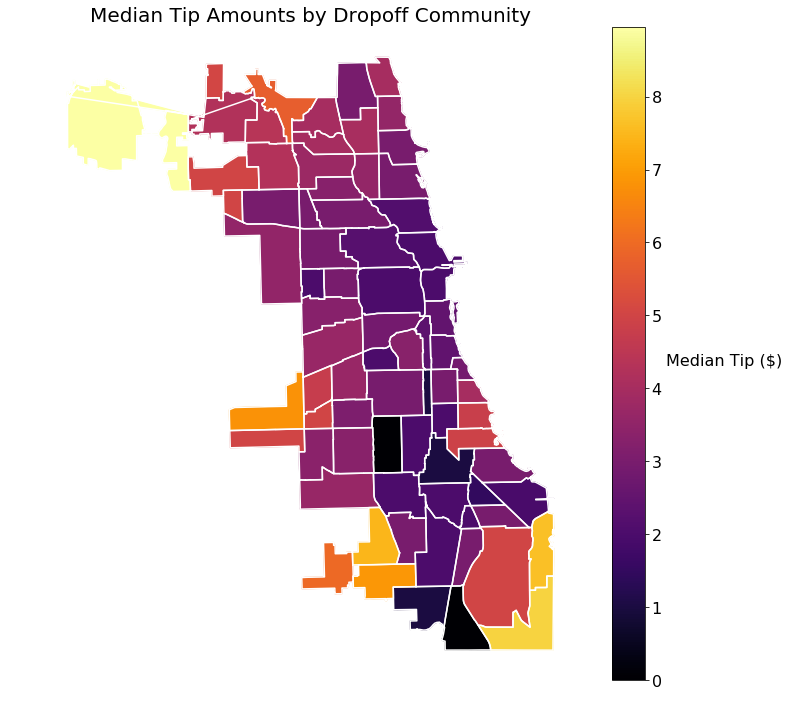

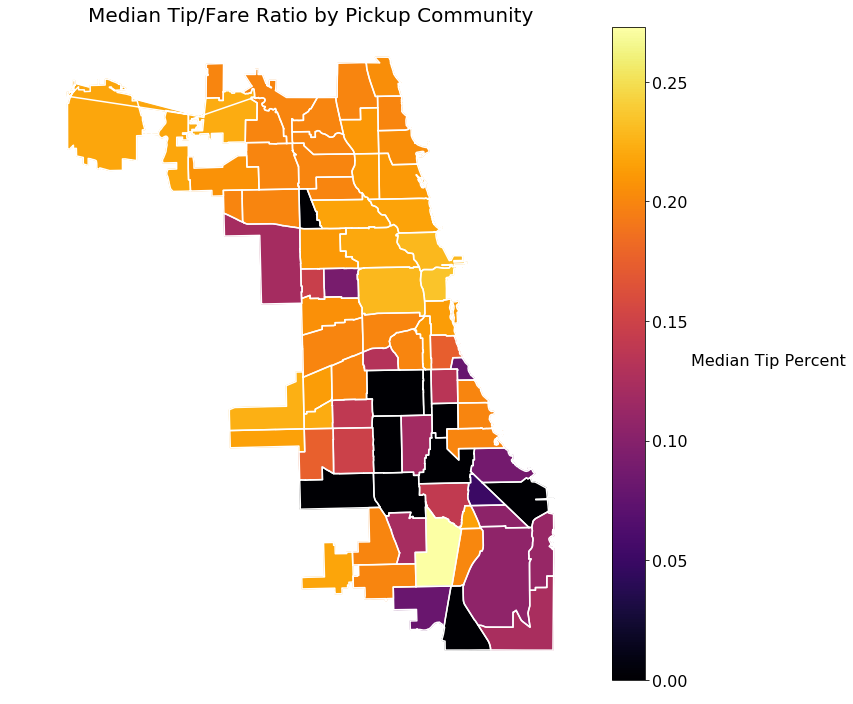

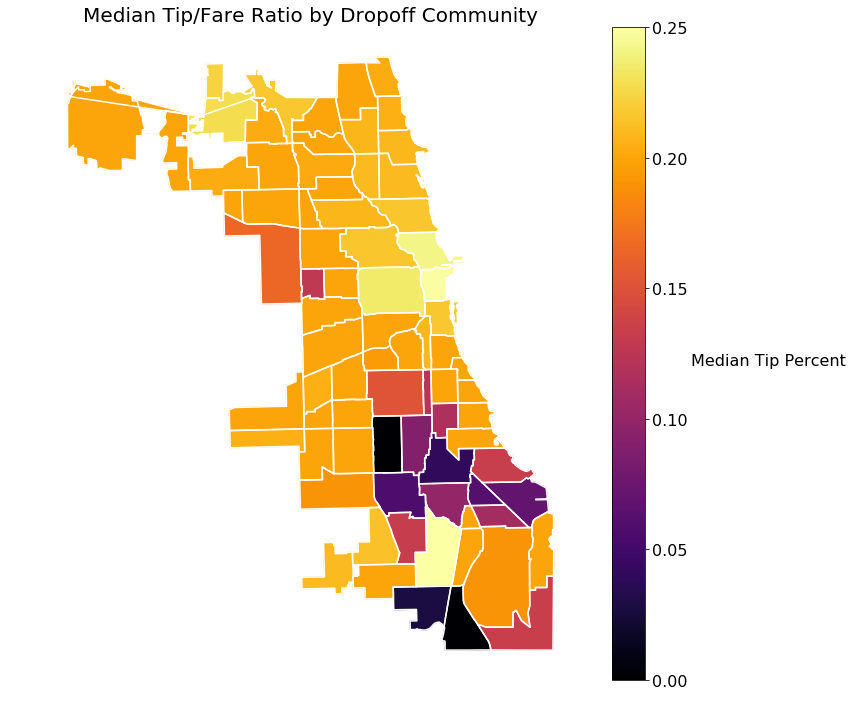

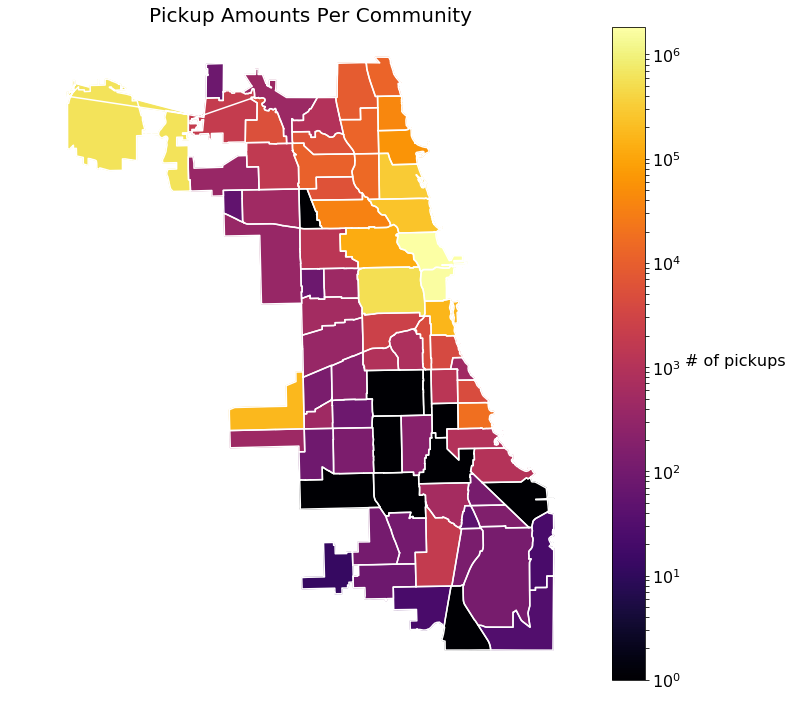

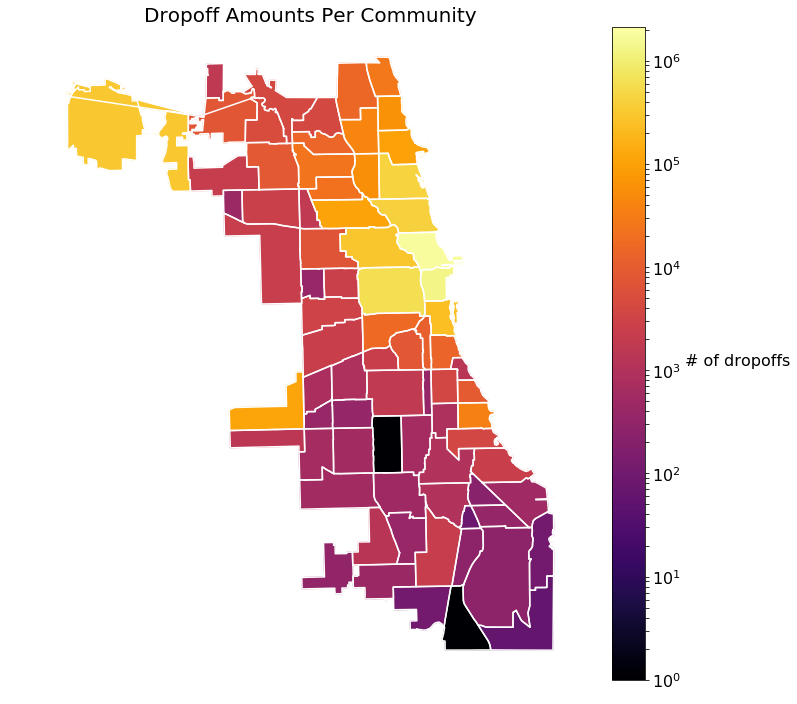

In [17]:
#Main map painter cell
sf = shp.Reader("community_areas.shp") #Shapefile for Chicago community areas

plt.figure(figsize=(12,12)) #Keep figures square
cmap = plt.get_cmap('inferno') #Color map palette
norm = mpl.colors.Normalize(vmin=0,vmax=8.95) #Normalization function for plain color normalization

for shape in sf.shapeRecords(): #Loop through each region in the shapefile
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y,color="White") #Draw white line around region
    if int(shape.record[0]) in tips_dropoff.groups: #If region number exists in dataset
        if tips_dropoff.get_group(int(shape.record[0])).mean() <= 0: #If value for region is negative or zero, paint black
            plt.fill(x,y,color=cmap(0))
        else: #Otherwise, fill region with color mapped to median value for region
            plt.fill(x,y,color=cmap(norm(tips_dropoff.get_group(int(shape.record[0])).median())))
    else:
        plt.fill(x,y,color=cmap(0)) #If region doesn't exist, fill black
plt.title('Median Tip Amounts by Dropoff Community', fontsize=20)
plt.axis('off')

#Set up colorbar for plot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=plt.colorbar(sm)
cbar.set_label('Median Tip ($)', rotation=0, ha='left', fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.figure(figsize=(12,12))
#cmap = plt.get_cmap('inferno')
norm = mpl.colors.Normalize(vmin=0,vmax=.2727)
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y,color="White")
    if int(shape.record[0]) in tfr_pickup.groups:
        if tfr_pickup.get_group(int(shape.record[0])).mean() <= 0:
            plt.fill(x,y,color=cmap(0))
        else:
            plt.fill(x,y,color=cmap(norm(tfr_pickup.get_group(int(shape.record[0])).median())))
    else:
        plt.fill(x,y,color=cmap(0))
plt.title('Median Tip/Fare Ratio by Pickup Community', fontsize=20)
plt.axis('off')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=plt.colorbar(sm)
cbar.set_label('Median Tip Percent', rotation=0, ha='left', fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.figure(figsize=(12,12))
#cmap = plt.get_cmap('inferno')
norm = mpl.colors.Normalize(vmin=0,vmax=.25)
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y,color="White")
    if int(shape.record[0]) in tfr_dropoff.groups:
        if tfr_dropoff.get_group(int(shape.record[0])).median() <= 0:
            plt.fill(x,y,color=cmap(0))
        else:
            plt.fill(x,y,color=cmap(norm(tfr_dropoff.get_group(int(shape.record[0])).median())))
    else:
        plt.fill(x,y,color=cmap(0))
plt.title('Median Tip/Fare Ratio by Dropoff Community', fontsize=20)
plt.axis('off')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=plt.colorbar(sm)
cbar.set_label('Median Tip Percent', rotation=0, ha='left', fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.figure(figsize=(12,12))
#cmap = plt.get_cmap('inferno')
norm = mpl.colors.LogNorm(vmin=1,vmax=1816416)  #Since rides are so focused in downtown area, I use a Log normalization
                                                #to show differences in rides in other less used areas
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y,color="White")
    if int(shape.record[0]) in tfr_pickup.groups:
        if tfr_pickup.get_group(int(shape.record[0])).median() <= 0:
            plt.fill(x,y,color=cmap(0))
        else:
            plt.fill(x,y,color=cmap(norm(tfr_pickup.get_group(int(shape.record[0])).count())))
    else:
        plt.fill(x,y,color=cmap(0))
plt.title('Pickup Amounts Per Community', fontsize=20)
plt.axis('off')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=plt.colorbar(sm)
cbar.set_label('# of pickups', rotation=0, ha='left', fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.figure(figsize=(12,12))
#cmap = plt.get_cmap('inferno')
norm = mpl.colors.LogNorm(vmin=1,vmax=2096837)
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y,color="White")
    if int(shape.record[0]) in tfr_dropoff.groups:
        if tfr_dropoff.get_group(int(shape.record[0])).median() <= 0:
            plt.fill(x,y,color=cmap(0))
        else:
            plt.fill(x,y,color=cmap(norm(tfr_dropoff.get_group(int(shape.record[0])).count())))
    else:
        plt.fill(x,y,color=cmap(0))
plt.title('Dropoff Amounts Per Community', fontsize=20)
plt.axis('off')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=plt.colorbar(sm)
cbar.set_label('# of dropoffs', rotation=0, ha='left', fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.show()

In [ ]:
#Outline of how to create Chicago map
sf = shp.Reader("community_areas.shp") #shp file needed as well as dbf file of same name
plt.figure(figsize=(12,12))
cmap = plt.get_cmap('magma') #color scheme name
norm = mpl.colors.Normalize(vmin=10,vmax=20) #normalize data here, put in your data min and max
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y,color="Black") #outline color
    if int(shape.record[0]) in aj_tips.groups: #shape.record[0] is the community area number
        plt.fill(x,y,color=cmap(norm(15))) #input value for community area in "norm()"
    else:
        plt.fill(x,y,color=cmap(0))
plt.title('Chicago Community Areas')
plt.axis('off')